# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.16.2-gamma'

### Dataset preparation
Download the datasets to "input" direcotry and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

In [6]:
# If you want to stop displaying figures when using interactive shell,
# snl.interactive = False
# For temporally, plese use snl.records(show_figure=False) etc.
# If you want save figures,
# snl.interactive = False
# and please use snl.records(filename="records.jpg") etc.

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

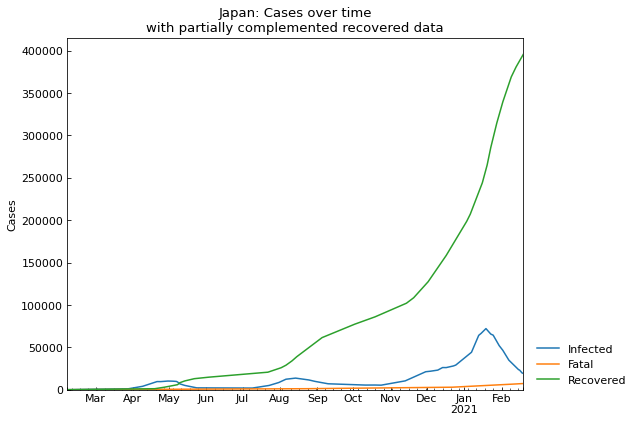

,Date,Infected,Fatal,Recovered
375,2021-02-15,23733,6952,385097
376,2021-02-16,23010,7015,387740
377,2021-02-17,20705,7102,391208
378,2021-02-18,19718,7196,393494
379,2021-02-19,19201,7274,395492


In [7]:
record_df = snl.records()
record_df.tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

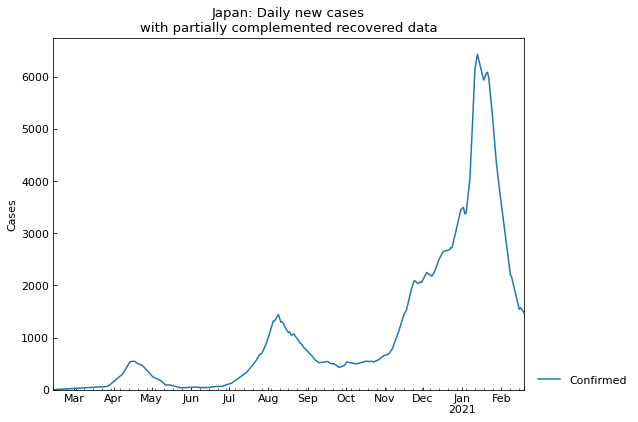

In [8]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

`Scenario.show_complement()` method is useful to show the kinds of complement. The details of complement are explained in [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html#The-number-of-cases-(JHU-style)) section.

In [9]:
complement_snl_df = snl.show_complement()
complement_snl_df.tail()

,Country,Province,Monotonic_confirmed,Monotonic_fatal,Monotonic_recovered,Full_recovered,Partial_recovered
0,Japan,-,False,False,True,False,True


### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

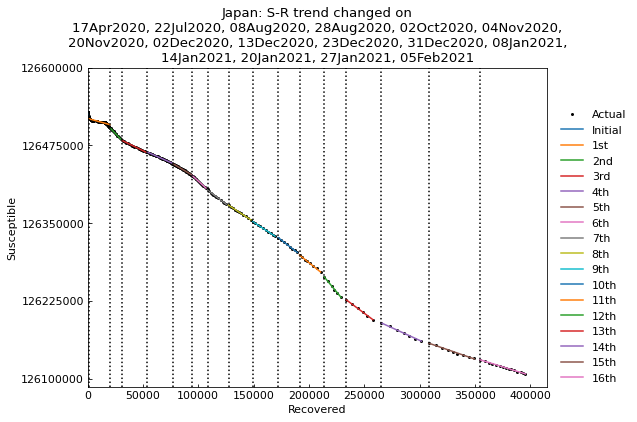

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,21Jul2020,126529100
2nd,Past,22Jul2020,07Aug2020,126529100
3rd,Past,08Aug2020,27Aug2020,126529100
4th,Past,28Aug2020,01Oct2020,126529100
5th,Past,02Oct2020,03Nov2020,126529100
6th,Past,04Nov2020,19Nov2020,126529100
7th,Past,20Nov2020,01Dec2020,126529100
8th,Past,02Dec2020,12Dec2020,126529100
9th,Past,13Dec2020,22Dec2020,126529100


In [10]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [11]:
# Estimate the parameter values of SIR-F model
# Default value of timeout is 180 sec
snl.estimate(cs.SIRF, timeout=60)


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	16th phase (05Feb2021 - 19Feb2021): finished  405 trials in 0 min 20 sec


	 4th phase (28Aug2020 - 01Oct2020): finished  461 trials in 0 min 50 sec

	 7th phase (20Nov2020 - 01Dec2020): finished  484 trials in 0 min 50 sec

	 2nd phase (22Jul2020 - 07Aug2020): finished  548 trials in 1 min  0 sec

	 5th phase (02Oct2020 - 03Nov2020): finished  554 trials in 1 min  0 sec

	 6th phase (04Nov2020 - 19Nov2020): finished  548 trials in 1 min  0 sec

	 0th phase (06Feb2020 - 16Apr2020): finished  534 trials in 1 min  0 sec

	 1st phase (17Apr2020 - 21Jul2020): finished  511 trials in 1 min  0 sec

	 3rd phase (08Aug2020 - 27Aug2020): finished  547 trials in 1 min  0 sec

	13th phase (14Jan2021 - 19Jan2021): finished  209 trials in 0 min 20 sec

	14th phase (20Jan2021 - 26Jan2021): finished  207 trials in 0 min 20 sec

	 9th phase (13Dec2020 - 22Dec2020): finished  375 trials in 0 min 40 sec

	10th phase (23Dec2020 - 30Dec2020): finished  393 trials in 0 min 40 sec

	 8th phase (02Dec2020 - 12Dec2020): finished  613 trials in 1 min  0 sec

	11th phase (31Dec2020 - 07Jan2021): finished  542 trials in 0 min 50 sec

	15th phase (27Jan2021 - 04Feb2021): finished  536 trials in 0 min 50 sec

	12th phase (08Jan2021 - 13Jan2021): finished  755 trials in 1 min  0 sec

Completed optimization. Total: 2 min 24 sec


In [12]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.75,0.000192,0.000619,0.020122,0.003616,288,0.000,322,55,9,0.297883,534,1 min 0 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.60,0.069185,0.000114,0.007970,0.012318,288,0.069,1760,16,25,0.421001,511,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,2.09,0.001606,0.000046,0.026536,0.012629,288,0.002,4366,15,7,0.029057,548,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.89,0.000287,0.000087,0.016793,0.018695,288,0.000,2302,10,11,0.050538,547,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.80,0.014710,0.000014,0.017057,0.021117,288,0.015,14069,9,11,0.037986,461,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.04,0.000066,0.000152,0.020614,0.019659,288,0.000,1318,10,9,0.039488,554,1 min 0 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.55,0.001008,0.000216,0.027339,0.017441,288,0.001,927,11,7,0.015221,548,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.43,0.000849,0.000150,0.024781,0.017214,288,0.001,1332,11,8,0.025514,484,0 min 50 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.22,0.000423,0.000361,0.020913,0.016782,288,0.000,553,11,9,0.017870,613,1 min 0 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.13,0.000656,0.000284,0.019769,0.017202,288,0.001,704,11,10,0.008817,375,0 min 40 sec


### Accuracy of estimation

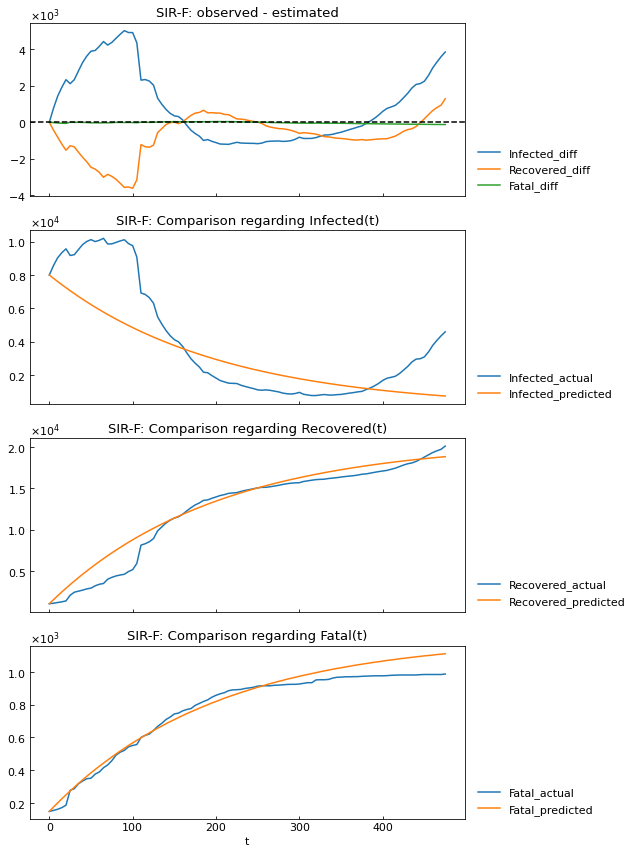

In [13]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [14]:
snl.get("Rt", phase="4th")

0.8

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

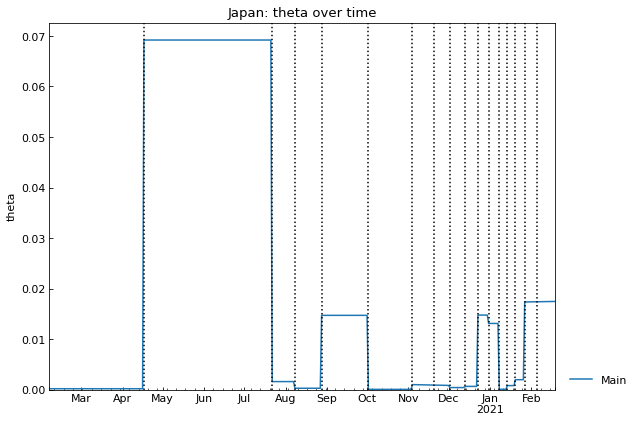

In [15]:
_ = snl.history(target="theta")

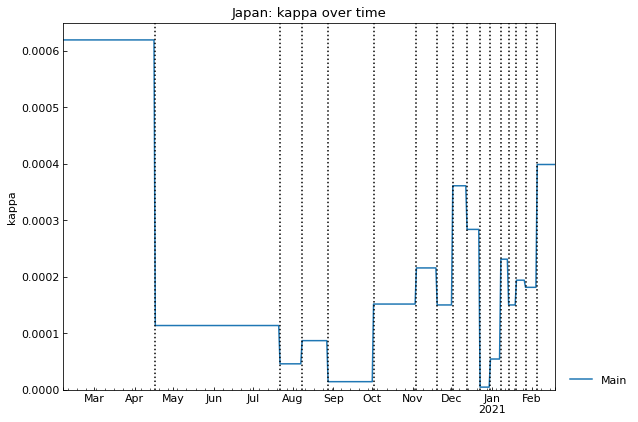

In [16]:
_ = snl.history(target="kappa")

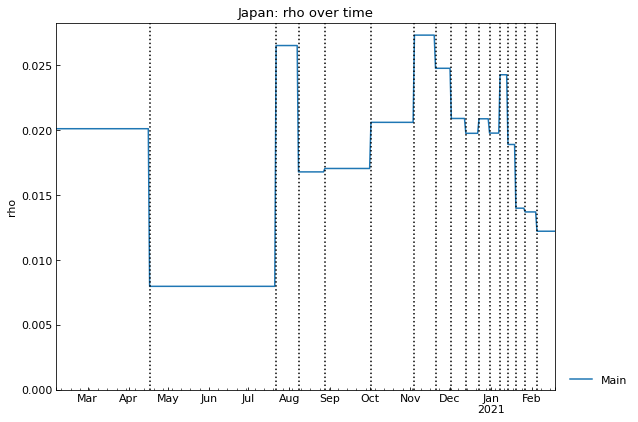

In [17]:
_ = snl.history(target="rho")

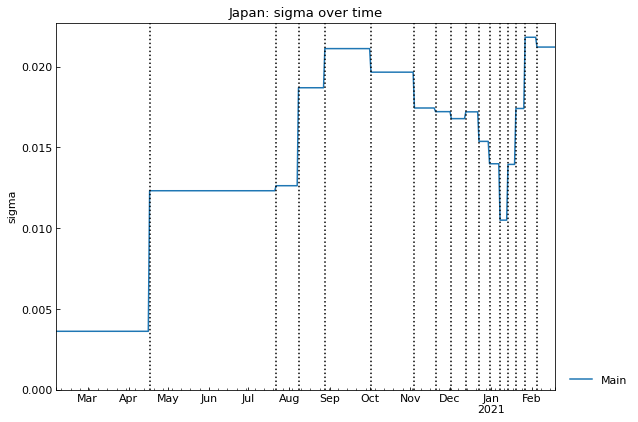

In [18]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

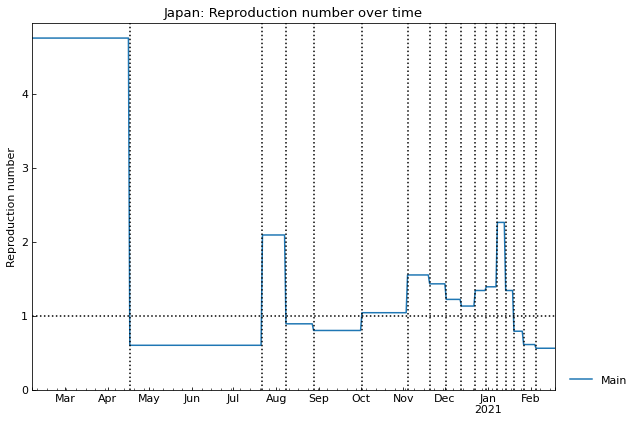

In [19]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

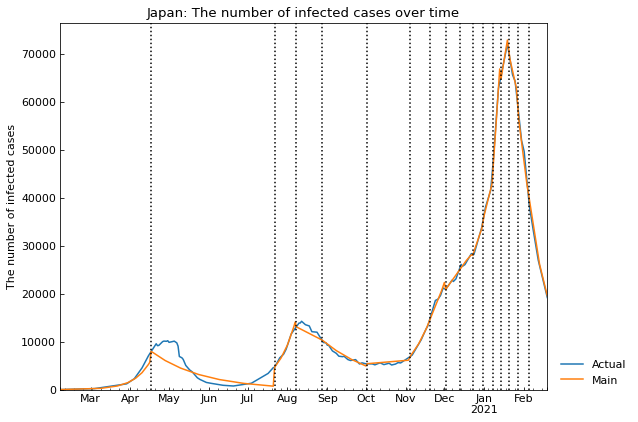

In [20]:
_ = snl.history("Infected")

### Main scenario
To investigate the effect of parameter changes, we will perform scenario analysis. In the main scenario, we will assume that the parameter values do not change after the last past phase.

i.e. If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

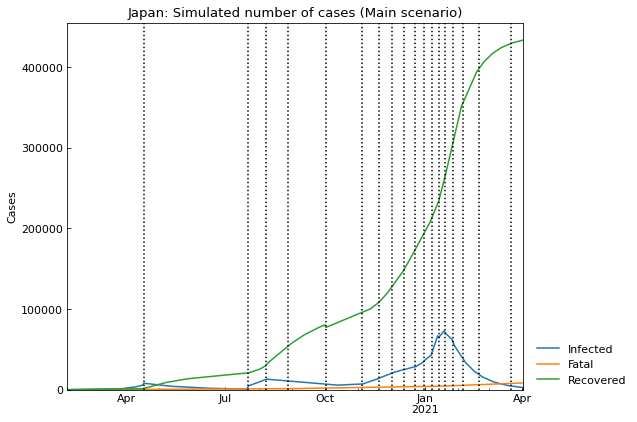

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,443618,8373,3135,432110
418,2021-03-30,443803,8382,2987,432434
419,2021-03-31,443981,8391,2846,432744
420,2021-04-01,444150,8400,2712,433038
421,2021-04-02,444312,8408,2585,433319


In [21]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
To investigate the effect of new medicines, we will assume that $\sigma$ will be changed in the future phases.

If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [22]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.021213102372803206

In [23]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.04242620474560641

In [24]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.75,0.000192,0.000619,0.020122,0.003616,288,0.000,322,55,9,0.297883,534,1 min 0 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.60,0.069185,0.000114,0.007970,0.012318,288,0.069,1760,16,25,0.421001,511,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,2.09,0.001606,0.000046,0.026536,0.012629,288,0.002,4366,15,7,0.0290568,548,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.89,0.000287,0.000087,0.016793,0.018695,288,0.000,2302,10,11,0.0505379,547,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.80,0.014710,0.000014,0.017057,0.021117,288,0.015,14069,9,11,0.0379858,461,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.04,0.000066,0.000152,0.020614,0.019659,288,0.000,1318,10,9,0.0394878,554,1 min 0 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.55,0.001008,0.000216,0.027339,0.017441,288,0.001,927,11,7,0.0152214,548,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.43,0.000849,0.000150,0.024781,0.017214,288,0.001,1332,11,8,0.0255143,484,0 min 50 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.22,0.000423,0.000361,0.020913,0.016782,288,0.000,553,11,9,0.0178699,613,1 min 0 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.13,0.000656,0.000284,0.019769,0.017202,288,0.001,704,11,10,0.00881676,375,0 min 40 sec


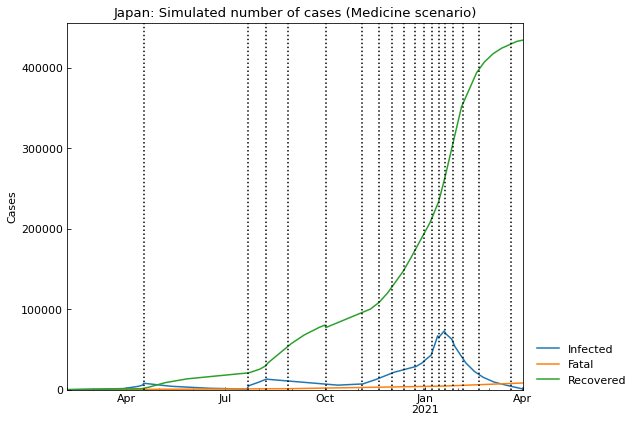

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,443172,8350,1491,433331
418,2021-03-30,443258,8355,1278,433625
419,2021-03-31,443329,8358,1095,433876
420,2021-04-01,443390,8361,939,434090
421,2021-04-02,443443,8364,805,434274


In [25]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay period (calculated with `cenario.estimate_delay()` with version > 2.15.0-beta or set as recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [26]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.6789808045220064 (train)
Determination coefficient: 0.7262039407719875 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing
theta,0.007261,0.020038,-0.017859,0.000000,-0.010360,0.052958,0.020038,0.010740,-0.005291,-0.072370,0.000000
kappa,0.000097,-0.000129,0.000121,0.000000,0.000065,-0.000441,-0.000129,-0.000014,-0.000002,0.000016,0.000000
rho,-0.002044,-0.003683,0.003230,0.000000,-0.000729,-0.008964,-0.003683,-0.002465,0.001291,0.015287,0.000000
sigma,-0.003659,0.002096,-0.002006,0.000000,-0.000174,0.008119,0.002096,-0.000177,0.000292,0.006691,0.000000


In [27]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.75,0.000192,0.000619,0.020122,0.003616,288,0.000,322,55,9,0.297883,534,1 min 0 sec
1st,Past,17Apr2020,21Jul2020,126529100,SIR-F,0.60,0.069185,0.000114,0.007970,0.012318,288,0.069,1760,16,25,0.421001,511,1 min 0 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,2.09,0.001606,0.000046,0.026536,0.012629,288,0.002,4366,15,7,0.0290568,548,1 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.89,0.000287,0.000087,0.016793,0.018695,288,0.000,2302,10,11,0.0505379,547,1 min 0 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.80,0.014710,0.000014,0.017057,0.021117,288,0.015,14069,9,11,0.0379858,461,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.04,0.000066,0.000152,0.020614,0.019659,288,0.000,1318,10,9,0.0394878,554,1 min 0 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.55,0.001008,0.000216,0.027339,0.017441,288,0.001,927,11,7,0.0152214,548,1 min 0 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.43,0.000849,0.000150,0.024781,0.017214,288,0.001,1332,11,8,0.0255143,484,0 min 50 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.22,0.000423,0.000361,0.020913,0.016782,288,0.000,553,11,9,0.0178699,613,1 min 0 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.13,0.000656,0.000284,0.019769,0.017202,288,0.001,704,11,10,0.00881676,375,0 min 40 sec


In [28]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values. Currently, we can compare the scenarios with the following indexes.

- max(Infected): max value of Infected
- argmax(Infected): the date when Infected shows max value
- Infected on …: Infected on the end date of the last phase
- Fatal on …: Fatal on the end date of the last phase

In [29]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 05Mar2021,Infected on 05Mar2021,Fatal on 05Mar2021,17th_Rt,18th_Rt
Main,72876,19Jan2021,444312.0,2585.0,8408.0,NaN,NaN,NaN,0.56,0.56
Medicine,72876,19Jan2021,443443.0,805.0,8364.0,NaN,NaN,NaN,0.56,0.28
Forecast,72876,19Jan2021,NaN,NaN,NaN,444140.0,18143.0,7860.0,0.98,-


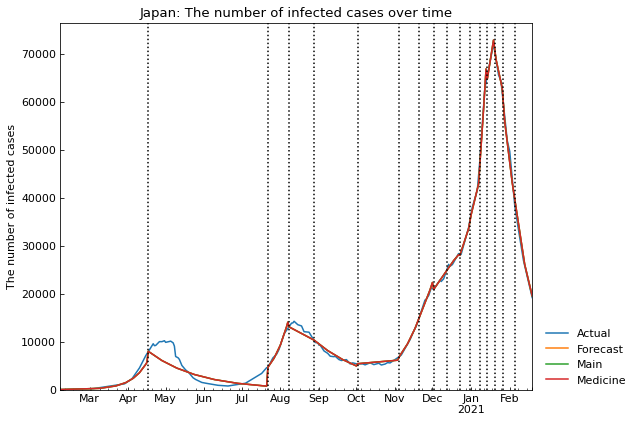

In [30]:
_ = snl.history(target="Infected")

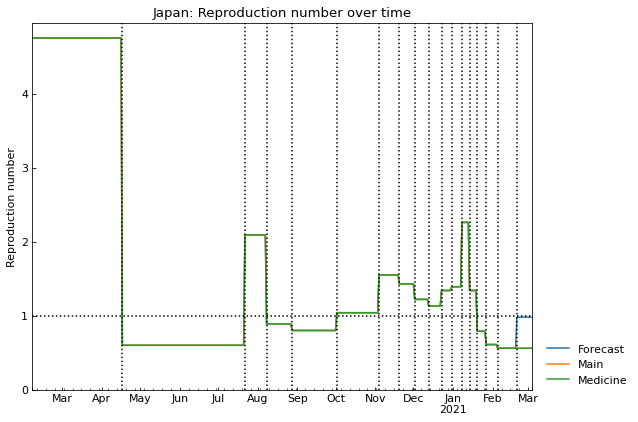

In [31]:
_ = snl.history(target="Rt")

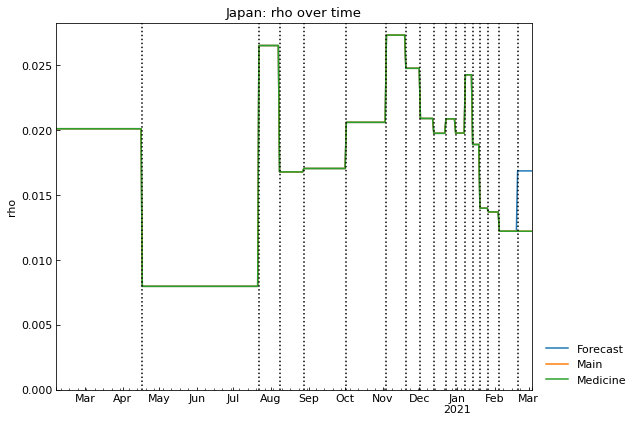

In [32]:
_ = snl.history(target="rho")

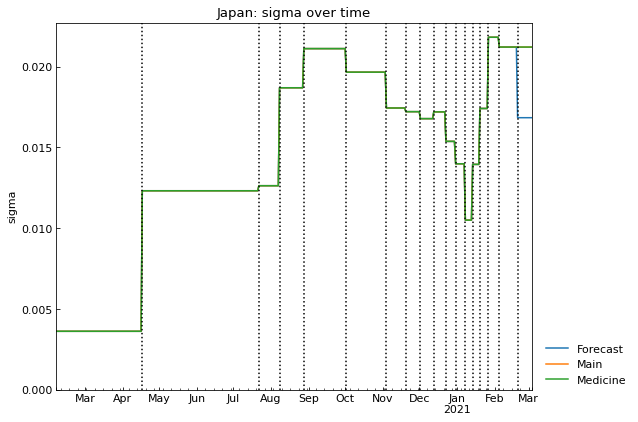

In [33]:
_ = snl.history(target="sigma")

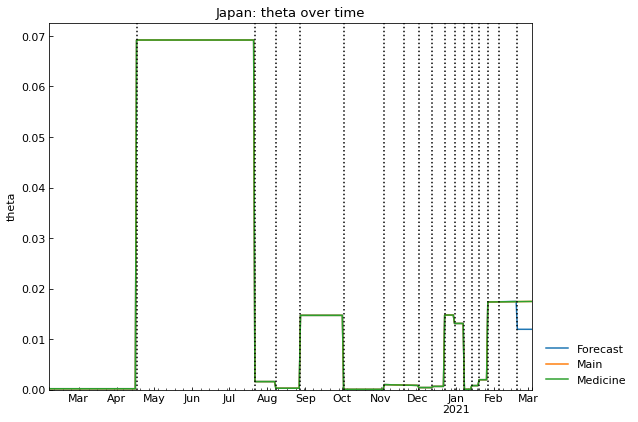

In [34]:
_ = snl.history(target="theta")

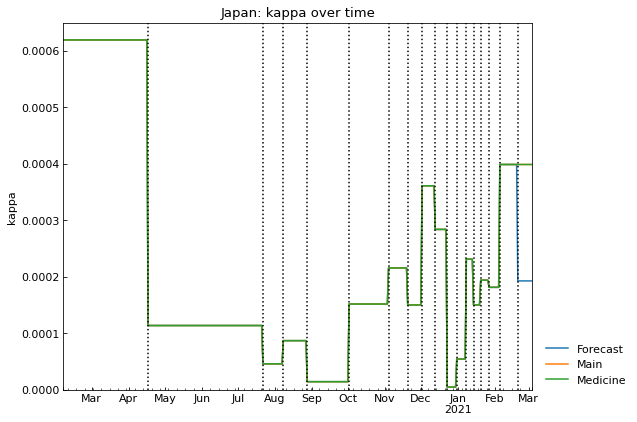

In [35]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

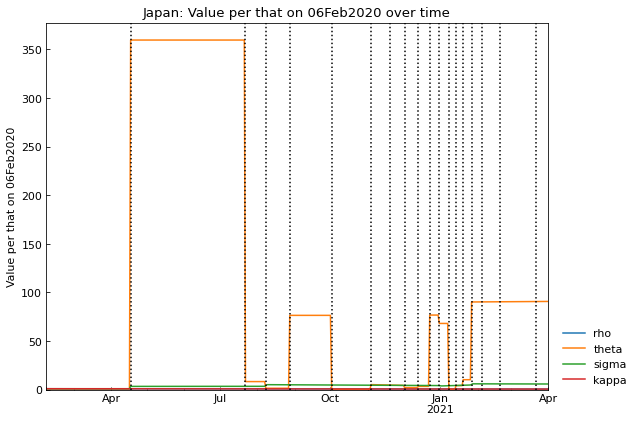

In [36]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [37]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	17th phase (05Feb2021 - 19Feb2021): finished  398 trials in 0 min 20 sec


	 4th phase (28Aug2020 - 31Aug2020): finished  209 trials in 0 min 20 sec

	 6th phase (02Oct2020 - 03Nov2020): finished  623 trials in 1 min 10 sec

	 8th phase (20Nov2020 - 01Dec2020): finished  474 trials in 0 min 50 sec

	 2nd phase (22Jul2020 - 07Aug2020): finished  704 trials in 1 min 20 sec

	 7th phase (04Nov2020 - 19Nov2020): finished  705 trials in 1 min 20 sec

	 0th phase (06Feb2020 - 16Apr2020): finished  671 trials in 1 min 21 sec

	 1st phase (17Apr2020 - 21Jul2020): finished  721 trials in 1 min 31 sec

	 5th phase (01Sep2020 - 01Oct2020): finished  832 trials in 1 min 41 sec

	 3rd phase (08Aug2020 - 27Aug2020): finished  901 trials in 1 min 51 sec

	14th phase (14Jan2021 - 19Jan2021): finished  171 trials in 0 min 20 sec

	11th phase (23Dec2020 - 30Dec2020): finished  363 trials in 0 min 40 sec

	10th phase (13Dec2020 - 22Dec2020): finished  415 trials in 0 min 50 sec

	15th phase (20Jan2021 - 26Jan2021): finished  275 trials in 0 min 30 sec

	12th phase (31Dec2020 - 07Jan2021): finished  412 trials in 0 min 50 sec

	16th phase (27Jan2021 - 04Feb2021): finished  475 trials in 0 min 40 sec

	13th phase (08Jan2021 - 13Jan2021): finished  707 trials in 1 min 10 sec

	 9th phase (02Dec2020 - 12Dec2020): finished 1459 trials in 2 min  1 sec

Completed optimization. Total: 3 min 35 sec



<SIR-F model: parameter estimation>
Running optimization with 8 CPUs...


	 5th phase (01Sep2020 - 19Feb2021): finished 1793 trials in 0 min 40 sec

Completed optimization. Total: 0 min 41 sec


In [38]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.75  0.000192  0.000619   
              1st    17Apr2020  21Jul2020  SIR-F  0.60  0.069185  0.000114   
              2nd    22Jul2020  07Aug2020  SIR-F  2.09  0.001606  0.000046   
              3rd    08Aug2020  27Aug2020  SIR-F  0.91  0.000086  0.000144   
              4th    28Aug2020  31Aug2020  SIR-F  0.80  0.014710  0.000014   
              5th    01Sep2020  01Oct2020  SIR-F  0.83  0.000413  0.000256   
              6th    02Oct2020  03Nov2020  SIR-F  1.04  0.000066  0.000152   
              7th    04Nov2020  19Nov2020  SIR-F  1.54  0.000086  0.000144   
              8th    20Nov2020  01Dec2020  SIR-F  1.43  0.000849  0.000150   
              9th    02Dec2020  12Dec2020  SIR-F  1.16  0.000647  0.000384   
              10th   13Dec2020  22Dec2020  SIR-F  1.13  0.000656  0.000284   
              11th   23Dec2020  30Dec2020  SIR-F  1.34  0.014769  0.000005   
              12th   31Dec2020  07Jan2021  SIR-F  1.39  0.013109  0.000054   
              13th   08Jan2021  13Jan2021  SIR-F  2.26  0.000079  0.000231   
              14th   14Jan2021  19Jan2021  SIR-F  1.34  0.000813  0.000150   
              15th   20Jan2021  26Jan2021  SIR-F  0.79  0.001978  0.000194   
              16th   27Jan2021  04Feb2021  SIR-F  0.61  0.017358  0.000181   
              17th   05Feb2021  19Feb2021  SIR-F  0.56  0.017463  0.000399   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.75  0.000192  0.000619   
              1st    17Apr2020  21Jul2020  SIR-F  0.60  0.069185  0.000114   
              2nd    22Jul2020  07Aug2020  SIR-F  2.09  0.001606  0.000046   
              3rd    08Aug2020  27Aug2020  SIR-F  0.91  0.000086  0.000144   
              4th    28Aug2020  31Aug2020  SIR-F  0.80  0.014710  0.000014   
              5th    01Sep2020  19Feb2021  SIR-F  0.80  0.014710  0.000014   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.020122  0.003616  0.297883     671  1 min 21 sec  
              1st    0.007970  0.012318  0.421001     721  1 min 31 sec  
              2nd    0.026536  0.012629  0.029057     704  1 min 20 sec  
              3rd    0.015636  0.017095  0.042010     901  1 min 51 sec  
              4th    0.016999  0.020900  0.009520     209  0 min 20 sec  
              5th    0.017637  0.021079  0.041221     832  1 min 41 sec  
              6th    0.020614  0.019659  0.039488     623  1 min 10 sec  
              7th    0.027629  0.017757  0.015029     705  1 min 20 sec  
              8th    0.024781  0.017214  0.025514     474  0 min 50 sec  
              9th    0.021028  0.017761  0.012990    1459  2 min  1 sec  
              10th   0.019769  0.017202  0.008817     415  0 min 50 sec  
              11th   0.020888  0.015374  0.008352     363  0 min 40 sec  
              12th   0.019784  0.013988  0.011027     412  0 min 50 sec  
              13th   0.024283  0.010498  0.014295     707  1 min 10 sec  
              14th   0.018906  0.013949  0.005574     171  0 min 20 sec  
              15th   0.013995  0.017411  0.010618     275  0 min 30 sec  
              16th   0.013706  0.021820  0.015550     475  0 min 40 sec  
              17th   0.012219  0.021213  0.014203     398  0 min 20 sec  
Retrospective 0th    0.020122  0.003616  0.297883     671  1 min 21 sec  
              1st    0.007970  0.012318  0.421001     721  1 min 31 sec  
              2nd    0.026536  0.012629  0.029057     704  1 min 20 sec  
              3rd    0.015636  0.017095  0.042010     901  1 min 51 sec  
              4th    0.016999  0.020900  0.009520     209  0 min 20 sec  
              5th    0.016999  0.020900  1.781992    1793  0 min 40 sec

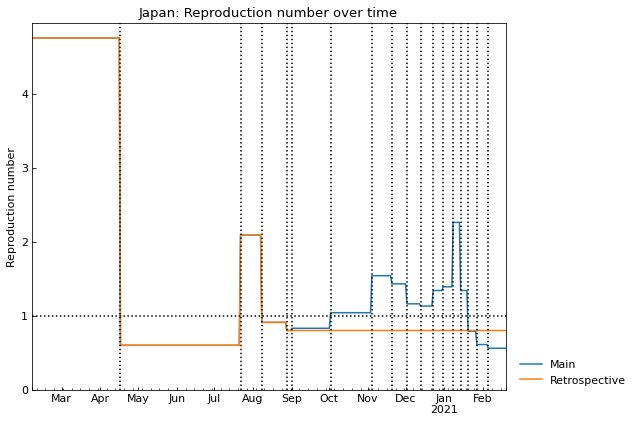

In [39]:
# History of reproduction number
_ = snl_retro.history("Rt")

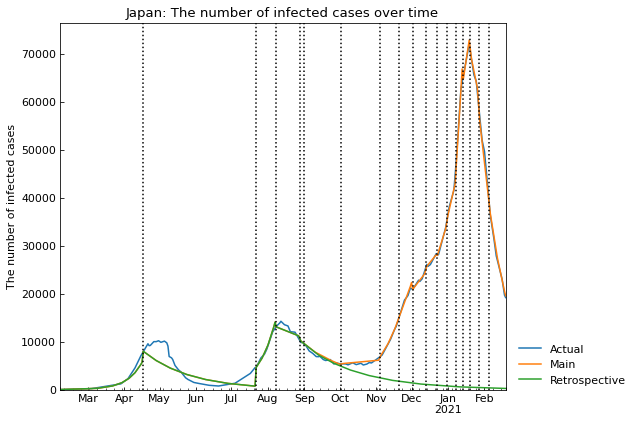

In [40]:
# History of Infected
_ = snl_retro.history("Infected")

In [41]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 20Feb2021,Infected on 20Feb2021,Fatal on 20Feb2021,5th_Rt,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt,14th_Rt,15th_Rt,16th_Rt,17th_Rt
Main,72876,19Jan2021,424040,18647,7390,0.83,1.04,1.54,1.43,1.16,1.13,1.34,1.39,2.26,1.34,0.79,0.61,0.56
Retrospective,14077,07Aug2020,105060,256,1866,0.80,-,-,-,-,-,-,-,-,-,-,-,-
